In [2]:
import pandas as pd
import csv

In [3]:
df_train = pd.read_csv('bert_all_prob.csv', engine='python')
embedding_filepath = 'glove.42B.300d.txt'
class_type = ['adhd', 'anxiety', 'bipolar', 'depression', 'eatingdisorders', 'ocd', 'ptsd', 'normal_positive','selfharm', 'stress']
        
#df_train = df_train[df_train['class'].isin(class_type)]
df_train.head()

,id,anger,annoyance,disappointment,disapproval,disgust,embarrassment,fear,grief,nervousness,remorse,sadness,positive,neutral,class,text,token,sentiment,token_count,text_length
0,0,0.011750,0.962781,0.012052,0.002271,0.007220,0.009971,0.050493,0.005130,0.059805,0.039979,0.045396,0.028717,0.010098,almosthomeless,I literally don’t know where to ask this but I...,liter dont know ask serious question advic pls...,-0.063889,38.0,85.0
1,1,0.003595,0.008378,0.049299,0.006292,0.006485,0.011670,0.028163,0.003882,0.064654,0.008756,0.908127,0.001446,0.008868,almosthomeless,I'm almost 16 and am going to study med but I ...,im almost go studi med need take coach henc m...,0.136364,29.0,58.0
2,2,0.011410,0.005968,0.025427,0.006605,0.007571,0.013576,0.845470,0.021448,0.343082,0.006201,0.701726,0.003424,0.027749,almosthomeless,"I got a job, I go to orientation Tuesday. Tomo...",got job go orient tuesday tomorrow homeless we...,0.050451,83.0,171.0
3,3,0.003747,0.010543,0.009026,0.031022,0.007493,0.008842,0.676281,0.004816,0.338001,0.007555,0.006759,0.005267,0.436492,almosthomeless,Struggling over here to get everything lined u...,struggl get everyth line upim need refug seek ...,-0.002083,119.0,228.0
4,4,0.003194,0.001744,0.005609,0.001580,0.006407,0.002710,0.005007,0.006430,0.008522,0.006978,0.476130,0.071973,0.222671,almosthomeless,Ill be homeless officially Monday. Moving out ...,ill homeless offici monday move sunday hope st...,-0.100000,39.0,81.0


In [4]:
df_train[['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness',
       'positive', 'neutral']].head()
len(['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness',
       'positive', 'neutral'])

13

In [5]:
print("Number of training samples: {}".format(len(df_train)))

Number of training samples: 14794


Let's visualize the distribution of class labels in form of a pie chart.

<Axes: >

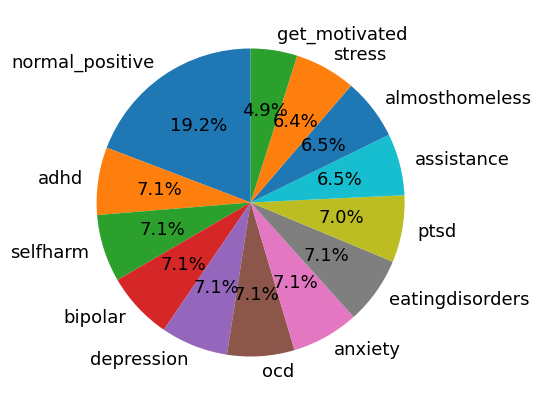

In [6]:
kwargs = dict(
    startangle = 90,
    fontsize   = 13,
    figsize    = (60,5),
    autopct    = '%1.1f%%',
    label      = ''
)

df_train['class'].value_counts().plot.pie(**kwargs)

In [7]:
len(df_train['class'].value_counts())

13

While not perfectly distributed, the class labels are arguebly well balanced.

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import spacy
from torchtext.vocab import GloVe, Vectors
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pack_sequence,pad_packed_sequence

In [9]:
def DataCleaning(df):
    #find duplicated text
    duplicated_texts = df[df.duplicated(['Text'], keep=False)]

    for text in duplicated_texts['Text'].unique():
        labels = duplicated_texts[duplicated_texts['Text']==text]['Label'].unique()
        if len(labels) > 1:
            #if there is different label, dirty, drop all
            df = df.drop(duplicated_texts[(duplicated_texts['Text']==text)].index)

    df = df.drop_duplicates(['Text'], keep='first')
    
    return df

In [10]:
from sklearn.preprocessing import LabelEncoder


class DEClassificationDataset(Dataset):
    def __init__(self, df, vocab,label_dict = None):
        self.df = df
        self.vocab = vocab
        self.tokenizer = spacy.load('en_core_web_sm')
        
        label_encoder = LabelEncoder()
        labels = label_encoder.fit_transform(df['class'])
        
        #self.label_dict = label_dict
        #if label_dict is None:
        #    self.label_dict = {item: index for index, item in enumerate(np.sort(np.unique(df['class'].to_numpy())))} 
        
        emo_col = ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness',
       'positive', 'neutral']
        texts = df['text'].values.tolist()
        emotions = df[emo_col].values.tolist()
        
        self.sample = []
        i= 0
        for text in tqdm(texts):
            #Convert word to word vector.
            tokens = [token.text.lower() for token in self.tokenizer(text)]
            indices = []
            for token in tokens:
                indices.append(np.array(self.vocab[token]))
            self.sample.append((torch.tensor(np.array(indices)), torch.tensor(np.array(emotions[i]))))
            i+=1
        
        if 'class' in df.columns:
            #Convert text Label to int Label.
            self.labels = labels
            self.labels = torch.tensor([element for element in self.labels],dtype=torch.long)
        else:
            #use id as label.
            self.labels = df['id'].values.tolist()
            
        #self.relabel_dict = {value: key for key, value in self.label_dict.items()}
    
    def int2label(self,labels):
        #int Label to text Label.
        return [self.relabel_dict[element] for element in labels]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.sample[idx],self.labels[idx]
    


In [11]:
def collate_fn(batch):
    #pad input for RNN.
    batch.sort(key=lambda x: len(x[0][0]), reverse=True)
    sequences, labels = zip(*batch)
    
    sequences_1 = [s[0] for s in sequences] 
    ems = [s[1] for s in sequences]
    
    seq_len = [s.size(0) for s in sequences_1] 
    padded_sequences = pad_sequence(sequences_1,batch_first=False)
    padded_sequences = pack_padded_sequence(padded_sequences, seq_len)
    labels = torch.tensor(labels, dtype=torch.long)
    ems = torch.stack(ems).float()

    
    return (padded_sequences,ems) , labels

In [12]:
glove = GloVe(name='840B', dim=300,cache='E:\\_temp_model\\.vector_cache')

word2vector = Vectors(name='model.txt', cache='E:\\_temp_model\\.vector_cache', 
                     url='http://vectors.nlpl.eu/repository/20/82.zip')

In [13]:
class LSTMClassifier(nn.Module):
    def __init__(self, hidden_dim = 100, output_dim = 5, n_layers = 2,
                 bidirectional=False, dropout = 0.3):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        #sample RNN to encode the word vector
        self.lstm = nn.LSTM(300, hidden_dim, num_layers=n_layers, 
                            bidirectional=bidirectional, dropout=dropout)
        #sample mlp for classify
        self.fc = nn.Sequential( #sample mlp for classify
            #nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, hidden_dim),
            nn.Linear(hidden_dim * 2+13 if bidirectional else hidden_dim+13, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1),
        )
        self.losses = []
        self.accs = []
        
        self.to(self.device)

    def forward(self, x,e):
        #print(e)
        lstm_output, _ = self.lstm(x)
        seq_unpacked, lens_unpacked = pad_packed_sequence(lstm_output,batch_first=False)
        #sum the output of each state, since pad words have value 0, ignore
        y = torch.sum(seq_unpacked,dim=0)
        y = torch.nn.functional.relu(y)
        
        #print(y)
        y = torch.cat((y,e),1)
        #print(y)
        y = self.fc(y)
        return y
    
    def fit(self, train_loader,test_loader=None,epoch = 10,optimizer=None):
        criterion = nn.CrossEntropyLoss()
        if optimizer is None:
            optimizer = optim.Adam(self.parameters(), lr=0.002)
        
        
        pbar = tqdm(range(epoch))
        for epoch in pbar:
            total_loss = 0
            for x,t in train_loader:  
                
                txt,ems = x
                txt = txt.to(self.device)
                ems = ems.to(self.device)
                t = t.to(self.device)
                optimizer.zero_grad()

                y = self(txt,ems)
                loss = criterion(y,t)
                total_loss+=loss.item()
                loss.backward()

                optimizer.step()
            total_loss = total_loss/len(train_loader)
            self.losses += [total_loss]
            
            if test_loader is not None:
                acc = self.evaluate(test_loader)
                self.accs+=[acc]
                pbar.set_description(f"total Loss: {total_loss}, acc: {acc}")
            else:
                pbar.set_description(f"total Loss: {total_loss}")
            
        fig, ax1 = plt.subplots(figsize=(6,4))

        ax1.plot(self.losses, color='blue')
        ax1.set_yscale('log')
        ax1.set_ylabel('log Loss', color='blue')
        
        if test_loader is not None:
            ax2 = ax1.twinx()
            ax2.plot(self.accs, color='red')
            ax2.set_ylabel('Test Accuracy', color='red')

        ax1.set_xlabel('Epoch')
        plt.title('Training Curves')
        plt.show()
            
    def evaluate(self,data_loader):
        total_correct = 0
        count = 0
        with torch.no_grad():
            for x,t in data_loader:
                
                txt,ems = x
                txt = txt.to(self.device)
                ems = ems.to(self.device)

                predictions = self(txt,ems).cpu().numpy()
                total_correct += np.sum(np.argmax(predictions,1)== t.cpu().numpy())
                count+=len(t)
        return total_correct/count
    
    def predict(self,data_loader):
        with torch.no_grad():
            ids = []
            predict_labels = []
            for x,t in data_loader:
                txt,ems = x
                txt = txt.to(self.device)
                ems = ems.to(self.device)
                
                predictions = self(txt,ems).cpu().numpy()
                predict_labels += list(np.argmax(predictions,1))
                ids += t
        return ids, predict_labels
    

In [14]:
#df = pd.read_csv("data/train.csv", sep="\t", quoting=csv.QUOTE_NONE)
filepath = 'bert_suicide_prob.csv'
df = pd.read_csv(filepath, engine='python', on_bad_lines='skip')
    
if filepath == 'bert_suicide_prob.csv' or 'suicide_probs.csv':
    class_type = ['suicide', 'non-suicide']
elif filepath == 'bert_all_prob.csv' or 'all_probs.csv':
    class_type = ['adhd', 'anxiety', 'bipolar', 'depression', 'eatingdisorders', 'ocd', 'ptsd', 'normal_positive','selfharm', 'stress']
        
df = df.dropna()
#class_type = ['adhd', 'anxiety', 'bipolar', 'depression', 'eatingdisorders', 'ocd', 'ptsd', 'normal_positive','selfharm', 'stress']
        
df = df[df['class'].isin(class_type)]
#df = DataCleaning(df)
train_df, test_df = train_test_split(df, test_size=0.2)

train_dataset = DEClassificationDataset(train_df,glove)
test_dataset = DEClassificationDataset(test_df,glove)

100%|██████████| 4196/4196 [01:14<00:00, 56.00it/s]


In [15]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=0,collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=0,collate_fn=collate_fn)

In [ ]:
lstm = LSTMClassifier(dropout=0.2,output_dim=len(df['class'].value_counts()),bidirectional=True,n_layers=2)
optimizer = optim.Adam(lstm.parameters(), lr=0.002)
lstm.fit(train_loader,test_loader,epoch=100,optimizer=optimizer)

total Loss: 0.3257914675456105, acc: 0.9413727359389895:  77%|███████▋  | 77/100 [1:18:44<23:38, 61.66s/it] 

In [ ]:

for x, t in test_loader:
    print(t)

In [ ]:
len(df['class'].value_counts())

In [ ]:
print(lstm.evaluate(test_loader))

In [ ]:
lstm.fit(train_loader,test_loader,epoch=20)

In [ ]:
lstm.fit(train_loader,test_loader,epoch=50)

In [ ]:
print(lstm.evaluate(test_loader))

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


all_predictions = []
all_labels = []

with torch.no_grad():
    for x, t in test_loader:
        txt, ems = x
        txt = txt.to(lstm.device)
        ems = ems.to(lstm.device)
        t = t.to(lstm.device)

        predictions = lstm(txt, ems).cpu()  # No need to convert to numpy here
        predicted_labels = torch.argmax(predictions, dim=1)
        
        all_predictions.extend(predicted_labels.numpy())
        all_labels.extend(t.cpu().numpy())

# Now we compute the confusion matrix and classification report
cm = confusion_matrix(all_labels, all_predictions)
cr = classification_report(all_labels, all_predictions, digits=3)

print("\nClassification Report:")
print(cr)


In [ ]:
#torch.save(lstm.state_dict(), 'all_data_model_parameters.pth')